In [1]:
using Pkg; Pkg.activate(".")
using Statistics
using PyPlot
using Glob
using DelimitedFiles
using MUST

MUST.@import_dispatch "../../../dispatch2" 
MUST.@import_dispatch "../../../dispatch2" EOS 
MUST.@get_help visual
pl =pyimport("matplotlib.pylab");

  Activating environment at `/cobra/ptmp/peitner/model_grid/MUST.jl/examples/visualize/Project.toml`


read the solar model

In [2]:
solar_model = readdlm("solar_model.txt");

Loading different models. It loads the normal, as well as the optical depth box.

In [3]:
function read_snaps(folder)
    content_of_folder = glob("*/", folder)
    snapshots         = sort(MUST.list_of_snapshots(content_of_folder));
    boxes  = []
    boxesT = []
    for (i_s,snap) in enumerate(snapshots)
        try
            # Also save the snapshot as Box (a regular gridded 3D-cube) to save time later
            append!(boxes, [MUST.Box("box_sn$(snapshots[i_s])", folder=folder)])
            append!(boxesT, [MUST.Box("box_tau_sn$(snapshots[i_s])", folder=folder)])
        catch
            @warn "could not load $(i_s)"
        end
    end
    boxes, boxesT
end;

In [4]:
folder = MUST.@in_dispatch "data/grid51_phase1"
m1 = read_snaps(folder);

┌ Warning: could not load 1
└ @ Main In[3]:12


In [6]:
folder2 = MUST.@in_dispatch "data/grid51_phase2"
m2 = read_snaps(folder2);

Load the suitable EOS

In [5]:
eos_sqg = MUST.SquareGasEOS(MUST.@in_dispatch("input_data/square_gas_1"));

In [6]:
units = MUST.StaggerCGS()

MUST.AtmosUnits("cgs", 1.0e8, 1.0e-7, 100.0, 1.0e6, 1.0e17, 100000.0, 0.09999999999999999, 1.0e12, 100000.0, 0.1, 1.0e-8, 1.3, 1120.9982432795857, 1.380658e-16, 1.6726219e-24, 6.65e-24)

In [9]:
MUST.lookup(eos_sqg, :Ne, 3e-7, 4.0 *units.ee) /(1/units.l^3)

7.787961477393085e37

Plot the diagnostics as plane averages

In [8]:
function plot_diags(boxes, x_axis, ax, colors, stat, diags...; funcs...)
    for i in 1:length(boxes)
        for j in 1:length(diags)
            v  = MUST.plane_statistic(stat, boxes[i], diags[j]) 
            if diags[j] in keys(funcs)
                v = funcs[diags[j]].(v)
            end
            t  = boxes[i][x_axis][1,1,:]
            if x_axis in keys(funcs)
                t = funcs[x_axis].(t)
            end
            ax[j].plot(t, v, label="$(i)", color=colors[i])
        end
    end
end

get_colors(cmap_name, cmap, boxes) = begin
    colors = cmap.(Vector(range(0.3,1.0; length=length(boxes))))
    sm     = plt.cm.ScalarMappable(cmap=cmap_name, norm=plt.Normalize(vmin=0, vmax=length(boxes)))
    (colors, sm)
end;

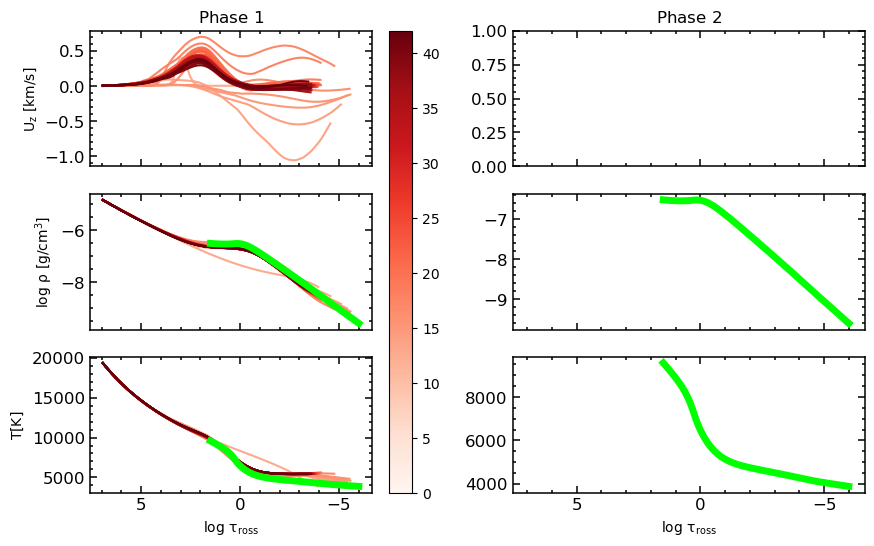

(7.591776037216187, -6.647227430343628)

In [9]:
f, ax = plt.subplots(3, 2, sharex=true, sharey=false, figsize=(10,6))
basic_plot!.(ax)

ax[1,1].set_ylabel(L"\rm U_z\ [km/s]")
ax[2,1].set_ylabel(L"\rm \log\ \rho\ [g/cm^3]")
ax[3,1].set_ylabel(L"\rm T [K]")

ax[3,1].set_xlabel(L"\rm \log\ \tau_{ross}\ ")
ax[3,2].set_xlabel(L"\rm \log\ \tau_{ross}\ ")

ax[1,1].set_title(L"\rm Phase\ 1")
ax[1,2].set_title(L"\rm Phase\ 2")

# First model
a = @view ax[:,1]
c1, sm1 = get_colors("Reds", plt.cm.Reds, m1[2])
plt.colorbar(sm1, ax=a)
plot_diags(m1[2], :τ_ross, a, c1, mean, :uz, :d, :T, d=log10, uz=x->x*1e-5)

# Second model
#a = @view ax[:,2]
#c2, sm2 = get_colors("Blues", plt.cm.Blues, m2[2])
#plt.colorbar(sm2, ax=a)
#plot_diags(m2[2], :τ_ross, a, c2, mean, :uz, :d, :T, d=log10, uz=x->x*1e-5)


# solar model
ax[2,1].plot(solar_model[:,2], solar_model[:,end], color="lime", lw=5)
ax[3,1].plot(solar_model[:,2], solar_model[:,3], color="lime", lw=5)
ax[2,2].plot(solar_model[:,2], solar_model[:,end], color="lime", lw=5)
ax[3,2].plot(solar_model[:,2], solar_model[:,3], color="lime", lw=5)

# revert xlim
ax[1,1].set_xlim(ax[1,1].get_xlim()[end:-1:1]...)

In [10]:
#gif_by_value(mean, folder, "logτ = 0",  variable=:T, clabel="T [K]", duration=0.2, τ_ross=0.0, path_ext="t00_nort", cmap="hot");
#gif_by_value(mean, folder2, "logτ = 0",  variable=:T, clabel="T [K]", duration=0.2, τ_ross=0.0, path_ext="t00_rt", cmap="hot");

In [12]:
size(m1[1][1].z)

(120, 120, 60)